# Laboratory 2.5: Logistic regression + regularization

Here we will construct our first instance of the **logistic regression classifier** and couple it with some ideas regarding **regularization**. As per usual, you will need the `synthetic_dataset.csv` present in the .zip file you downloaded alongside this notebook. In this case, you also have a `utils.py` file that contains several functions to diagnose your model. Check the inner contents of that file (you will see that there we have some functions you already constructed in previous labs, mostly related to the characterization of the fit).

In addition, we will be using the following libraries:
- Data management:
    - [numpy](https://numpy.org/)
    - [pandas](https://pandas.pydata.org/)
    - [scipy](https://scipy.org/)
- Modelling and scoring:
    - [scikit-learn](https://scikit-learn.org)
- Plotting:
    - [seaborn](https://seaborn.pydata.org/)
    - [matplotlib](https://matplotlib.org/)
    
### **All the things you need to do are marked by a "TODO" comment nearby. Make sure you *read carefully everything before working* and solve each point before submitting your solution.**

In [55]:
import numpy as np
import pandas as pd
import os
import sys
# Get the absolute path of the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add it to sys.path
sys.path.insert(0, project_root)

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# From the "utils.py" file you will only need this...
from src.utils import classification_report

The following cell defines the class for the logistic regression model. In here, we will recover the same structure we have followed thus far in the course, implementing the same models we have used before but now in this new context.

Here you can reuse the different functions you have implemented in previous notebooks to make your life easier (and, in fact, you will _need_ some of those functions here in order to make this model work).

**Before you start to work here, please read everything carefully, including the comments describing the inner workings of each method implemented. _Do not rush into writing code_, do things in an ordered fashion.**

For the initial part of the lab you will only need to complete the `.fit`, `.log_likelihood` and the `.sigmoid` method, since you will not perform regularization just yet. **Complete the code of this class as you need it**: Fill the `.fit` and the basic related methods as soon as you need it for later cells, leaving the regularization-related methods for later.

In [82]:
from src.Lab2_5_LogisticRegression_and_regularization import LogisticRegressor

Now, let us import the dataset, as usual. Load the `synthetic_data.csv` file and split it into `X` (inputs) and `y` (output). The input variables are named as `input_XX` and the (sole) target variable is named `target`. As you will see, it is a dataset where the target variable is binary categorical, coded with `1`s and `0`s.

In [48]:
df = pd.read_csv("../data/synthetic_dataset.csv", sep = ",")

# TODO: Separate the X and y values
X = df.drop(columns=['target']).values
y = df['target'].values

# Convert the pandas dataframes into np.arrays so that we can use all the previous codes we defined
# Warning: Watch out for the dimensions!!
X = np.array(X)
y = np.array(y)
print("Dimensiones de X:", X.shape)
print("Dimensiones de y:", y.shape)

Dimensiones de X: (5000, 20)
Dimensiones de y: (5000,)


Here you can employ previous code you developed in order to split the data into the two sets for training and testing. In this case, as we have done before, _we will purposefully forget about the validation set_ (it will come back next time, we promise...)

For now, we will give you the code to split the data into train/test using the proportion indicated via the `test_size` parameter. **_However, be sure to understand what is being done here, do not dismiss this step._**

In [59]:
def train_test_split(X, y, test_size=0.2, stratify=None, random_state=None):
    """
    Splits arrays or matrices into random train and test subsets. This function demonstrates how to
    divide a dataset into training and testing sets, optionally stratifying the samples and ensuring
    reproducibility with a random state.

    Parameters:
    - X (np.ndarray): Input features matrix, where rows represent samples and columns represent features.
    - y (np.ndarray): Target labels array, aligned with the samples in X.
    - test_size (float or int): Determines the size of the test set. If float, it represents a proportion
                                of the dataset; if int, it specifies the number of samples.
    - stratify (np.ndarray): If provided, the function will ensure the class proportions in train and test
                             sets mirror those of the provided array, typically the target labels array.
    - random_state (int): Seed for the random number generator to ensure reproducible splits.

    Returns:
    - X_train, X_test, y_train, y_test: Arrays containing the split of features and labels into training and
                                        test sets.
    """

    # Set the seed for reproducibility
    if random_state:
        np.random.seed(random_state)

    # Determine the number of samples to allocate to the test set
    n_samples = X.shape[0]
    if isinstance(test_size, float):
        n_test = int(n_samples * test_size)
    else:
        n_test = test_size
    n_train = n_samples - n_test

    # Create an array of indices and shuffle if not stratifying
    indices = np.arange(n_samples)
    if stratify is None:
        np.random.shuffle(indices)
    else:
        # For stratified splitting, determine the distribution of classes
        unique_classes, y_indices = np.unique(stratify, return_inverse=True)
        class_counts = np.bincount(y_indices)
        test_counts = np.round(class_counts * test_size).astype(int)

        # Allocate indices to train and test sets preserving class distribution
        train_indices, test_indices = [], []
        for class_index in range(len(unique_classes)):
            class_indices = indices[y_indices == class_index]
            np.random.shuffle(class_indices)
            boundary = test_counts[class_index]
            test_indices.extend(class_indices[:boundary])
            train_indices.extend(class_indices[boundary:])

        # Concatenate indices to form the final split
        indices = train_indices + test_indices

    # Use the indices to partition the dataset
    X_train = X[indices[:n_train]]
    X_test = X[indices[n_train:]]
    y_train = y[indices[:n_train]]
    y_test = y[indices[n_train:]]

    return X_train, X_test, y_train, y_test


Now that you have the train/test split function, perform the split in your data in the following cell:

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Training the logistic regression model

Now, it comes the turn to train the logistic regression. Remember, **this model does not have a closed-form solution for the values of the parameters, so instead you have to optimize the parameters recursively via an approximate technique**. There are many different approaches here, but we will resort to the most familiar one: _**gradient descent**_.

In [61]:
# Configuration of logistic regression model
num_iterations = 1000      # Number of iterations to run the gradient_descent algorithm
learning_rate = 0.01       # Learning rate parameter for gradient descent

# You can try different values for these parameters here!
# Watch out: Some values create unexpected responses of the model, so be careful...

Once you have the code, _let's get ready!_

Create an instance of your `LogisticRegressor` and run the fit. This should call the `fit` method, which should contain almost the same thing you had in the previous practice for the `fit_gradient_descent` method. You will need to tune it a bit so that it updates the parameters accordingly, but once you have it, you can run the following cell.

In [62]:
LogReg = LogisticRegressor()
LogReg.fit(X_train, y_train, learning_rate=learning_rate, num_iterations=num_iterations, verbose=True)

Iteration 0: Loss 0.6931471805599454
Iteration 100: Loss 0.36198273068074266
Iteration 200: Loss 0.3281699516241884
Iteration 300: Loss 0.3176380673802242
Iteration 400: Loss 0.3132191702005506
Iteration 500: Loss 0.3110856194047283
Iteration 600: Loss 0.309968760497831
Iteration 700: Loss 0.30935299690280654
Iteration 800: Loss 0.3090011590957817
Iteration 900: Loss 0.30879482551118337


Once the model is fitted, you can try to extract the prediction probabilities for each data point. To this end, extract the predicted probabilities for associated for the predicted values of `y_train` and `y_test`

In [63]:
# Predict probabilities of train and test datasets
y_train_prob = LogReg.predict_proba(X_train)
y_test_prob = LogReg.predict_proba(X_test)

You will use these values in just a second...

## Fit assessment

In order to see how well our model fits the data, we must resort to the techniques we have constructed in previous laboratories. In particular, we will use the function `classification_report` present in `utils.py`. We strongly encourage you to check out the functions present in that file, as you will see that they represent (our version of) certain functions that may look familiar.

In particular, take a look at the `classification_report` function. Before you continue, **what does this function do, how do you use it and why could it be interesting for your task here?**
> Write your answer here: Esta función te sirve para analizar como de bien se ajusta el modelo a los datos, y  puedes ver muy fácilmente si hace un buen trabajo gracias a los parámetros que te devuelve (Confusion Matrix, Accuracy, Precision, Recall (Sensitivity), Specificity, F1 Score) y las gráficas (calibration curves, probability histograms, and ROC curves).


Once you have answered the previous question, let us appy `classification_report` to the fit we obtained. Execute it in the next cell and check out the results.

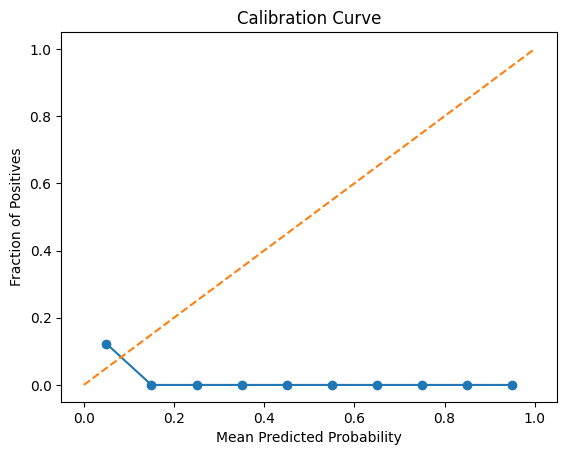

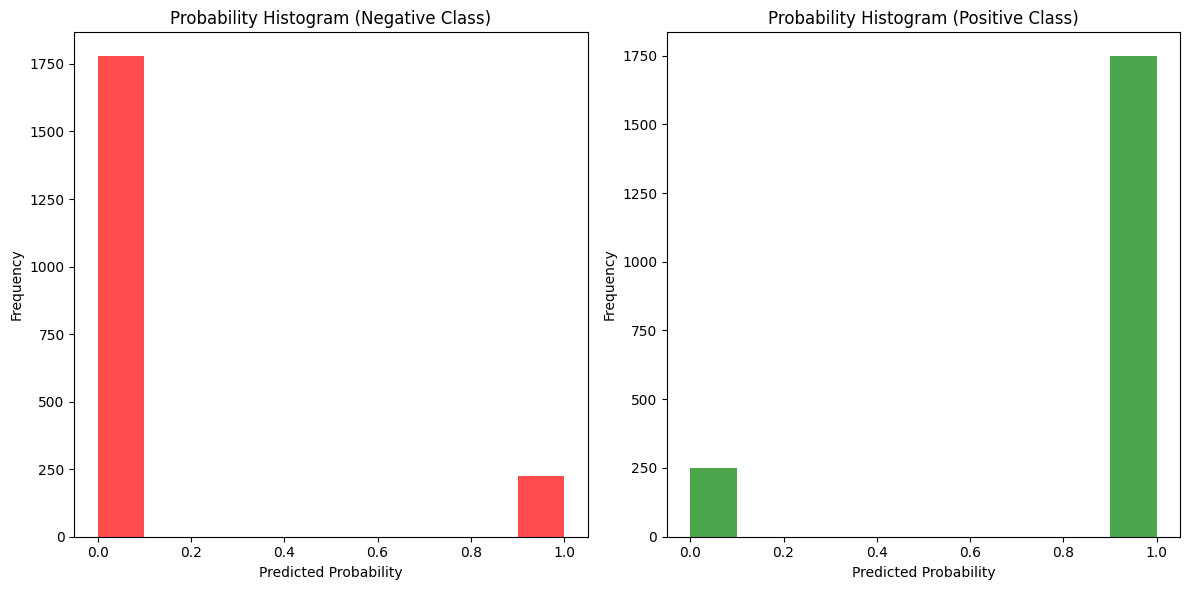

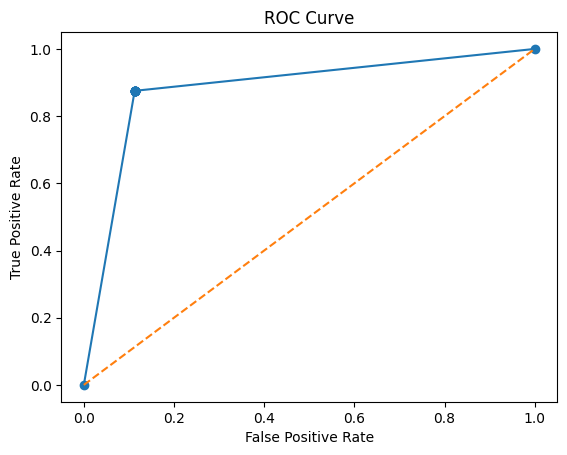

{'Confusion Matrix': [1778, 226, 249, 1747],
 'Accuracy': 0.88125,
 'Precision': 0.88545362392296,
 'Recall': 0.875250501002004,
 'Specificity': 0.8872255489021956,
 'F1 Score': 0.8803224993701184}

In [64]:
# TODO: Apply the classification_report function for the **TRAIN dataset predictions**
y_train_pred = (y_train_prob >= 0.5).astype(int)
classification_report(y_train, y_train_pred , 1)

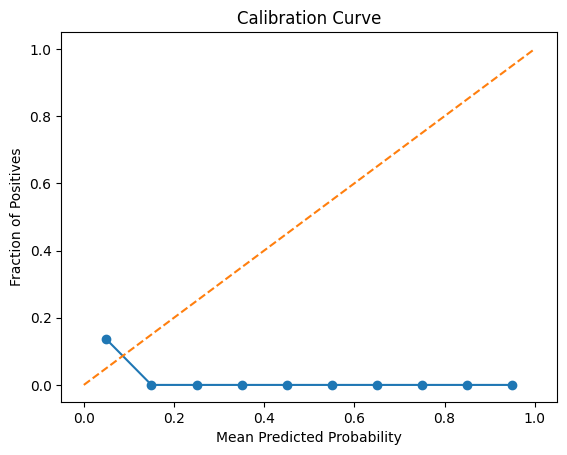

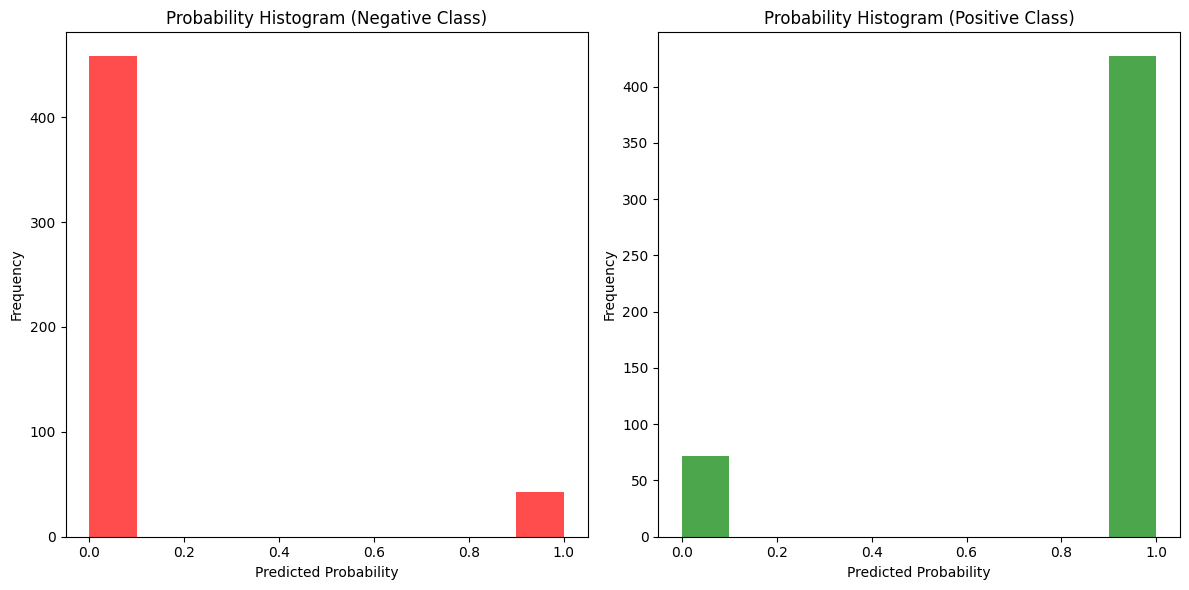

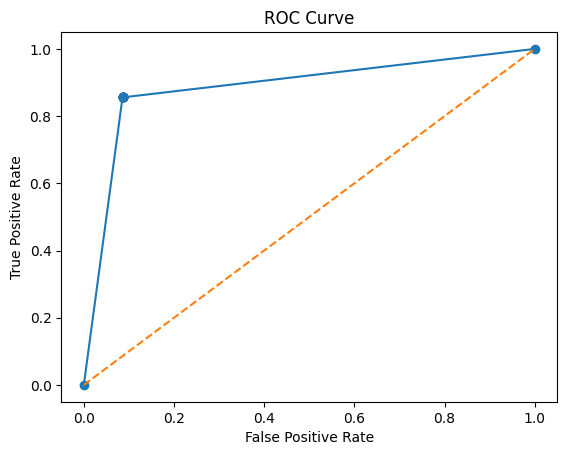

{'Confusion Matrix': [458, 43, 72, 427],
 'Accuracy': 0.885,
 'Precision': 0.9085106382978724,
 'Recall': 0.8557114228456913,
 'Specificity': 0.9141716566866267,
 'F1 Score': 0.8813209494324046}

In [65]:
# TODO: Apply the classification_report function for the **TEST dataset predictions**
y_test_pred = (y_test_prob >= 0.5).astype(int)
classification_report(y_test, y_test_pred, 1)


**What do you think about this results? Do you observe any important features that you think are worth mentioning?**

> Write your answer here: Como el modelo no se ajusta en absoluto, indica que no hay ningún patrón entre las predicciones del modelo y los valores observados. Es decir, el modelo no puede predecir con precisión los valores observados.

## Weights and regularization of the model

Now we have obtained our first fully-functional model of logistic regression (_congrats!_).

However, in our dataset we have ___ numerical regressors and ___ categorical regressors. Thus, we have a total of ___ input variables (columns) for the model, which entails a total of ___ parameters for the logistic regression model.

> Fill the gaps in the text above


However, in our dataset we have n numerical regressors and m categorical regressors. Thus, we have a total of n+m input variables (columns) for the model, which entails a total n+m+1 parameters for the logistic regression model.

Since we have **not** conducted preprocessing procedure for the dataset, we may be "doing more than we need". In this case, we have purposefully left out the preprocessing steps so you can see the effects of the next part of this lab: **regularization**.

As you may recall, regularization implies modifying the objective (loss) function a bit in order to reduce the overall complexity of the model. In most cases, complexity is translated into high weight (parameter) values, and thus penalizing large values here will help the model to keep a more reasonable balance in the *bias/variance* trade-off.

In class we introduced three main regularization techniques: **ridge**, **lasso** and **elastic net** regularization. Each one of those has their special properties, which we will investigate in just a second. Keep in mind, in each case, that modifying the objective function induces a change in the gradients of the gradient descent algorithm, which is why each regularization technique is able to affect the final values for the parameters of the fit.

_If you need to review the ideas behind regularization, now is the time. Make sure you get the gist of it before you continue._

**To perform the things you will need in the next part, you will need to implement the methods `ridge_regularization`, `lasso_regularization` and `elastic_net_regularization` in `LogisticRegressor`**.

### Ridge regularization

**Ridge regularization is performed introducing what in the objective function?**

> Write your answer here:It is performed by introducing L2 norm of the coefficients into the objective function. This is also added to the original loss function and it helps regularize the model by penalizing large coefficients, which prevents overfitting.


Once you have this, let us implement it already!

In [66]:
# We will perform regularization for different values of the regularization parameter
# TODO: Create an array (C_values) that contains 11 values distributed in log-scale, covering from 10^(-5) to 10^5
pow_min = -5
pow_max = 5
C_values = np.logspace(pow_min, pow_max, num=11)  # Vector of \lambda (regularization parameters)

# Keep these two empty lists to contain the final weights for each regularization parameter
weights_evolution = []    # To store the final weights for each C
accuracies = []           # To store accuracy for each C


Now, fit a logistic regression with ridge regularization for each possible value of the regularization parameter present in `C_values`.

In [67]:
for C in C_values:
    model = LogisticRegressor()  # Update to include necessary parameters
    model.fit(X, y, C= C)
    weights_evolution.append(model.weights)

    # Predict and calculate accuracy in the test data
    y_pred = model.predict(X)
    #y_pred = (model.predict_proba(X) >= 0.5).astype(int)
    accuracy = accuracy_score(y, y_pred)
    accuracies.append(accuracy)

Now, in order to see how well the model behaves, we will plot different things we have access to. This means that we want to plot:
* The evolution for each weight vs. the regularization parameter
* The accuracy of the method vs. the regularization parameter.
    - In this case, mark also the value of the regularization that achieves the highest accuracy
    
**What is the regularization value that achieves highest accuracy?**


  Para encontrar el mejor valor de regularización utilizamos la funcion accuracy_score para crear una lista de posibles valores mediante la y y la y_pred, y a partir de esta lista utilizamos la función max para encontrar el valor que nos da el máximo accuracy.

The optimum value of C based on accuracy is: 100000.0


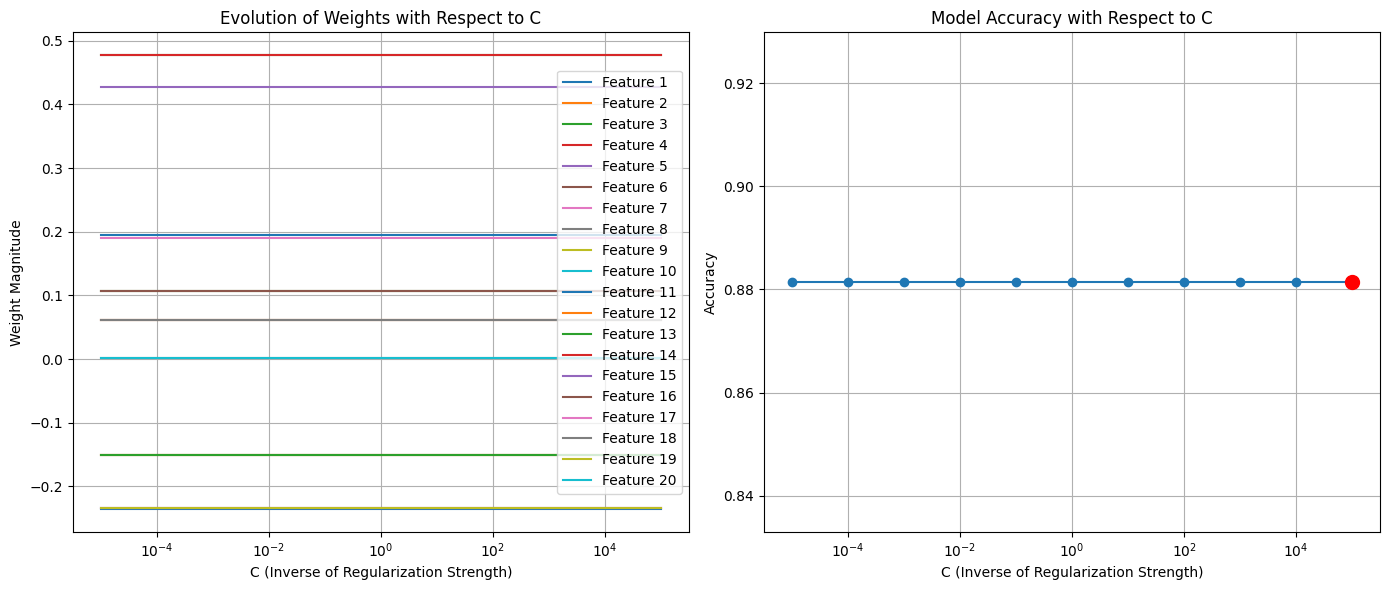

In [68]:
# Plotting the evolution of weights
plt.figure(figsize=(14, 6))

# Plot for the changes in the weights in terms of the regularization parameter
plt.subplot(1, 2, 1)
for feature_index in range(len(weights_evolution[0])):
    weight_trajectory = [weights[feature_index] for weights in weights_evolution]
    plt.plot(C_values, weight_trajectory, label=f'Feature {feature_index + 1}')
plt.xscale('log')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Weight Magnitude')
plt.title('Evolution of Weights with Respect to C')
plt.legend(loc='best')
plt.grid(True)

# TODO: Find the maximum accuracy
max_accuracy = max(accuracies)

# TODO: Filter the C values that correspond to the maximum accuracy
optimum_C_values = optimum_C_values = [C_values[i] for i, acc in enumerate(accuracies) if acc == max_accuracy]

# Select the maximum C from those that yield the highest accuracy
optimum_C = max(optimum_C_values)


print(f"The optimum value of C based on accuracy is: {optimum_C}")

# Plotting accuracy as a function of C
plt.subplot(1, 2, 2)
plt.plot(C_values, accuracies, marker='o', linestyle='-')
plt.plot(optimum_C, max_accuracy, 'ro', markersize=10, label='Optimum C')
plt.xscale('log')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Model Accuracy with Respect to C')
plt.grid(True)

plt.tight_layout()
plt.show()

Now, using the model fit with the regularization parameter that induces the highest accuracy, we will create a separate object and train it in the training data with this optimum value of the regularization parameter. We will do this to ease further treatment to measure the performance of this preferred method with the `classification_report` function.

In [69]:
# Initialize the LogisticRegressor model with the optimum C
LogReg_optimum_C_Ridge = LogisticRegressor()

# TODO: Train the model using the training data and the optimum C
LogReg_optimum_C_Ridge.fit(X_train, y_train,
                           learning_rate = learning_rate,
                           num_iterations = num_iterations,
                           penalty = 'ridge',
                           C = optimum_C)

Obtain the predictive probabilities for the `y_test`and apply the `classification_report` to check out the results.

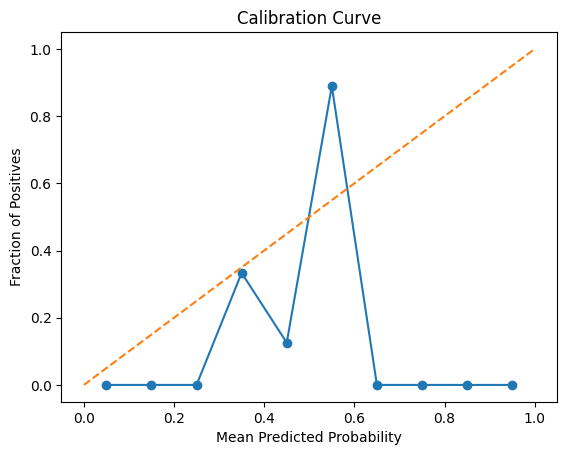

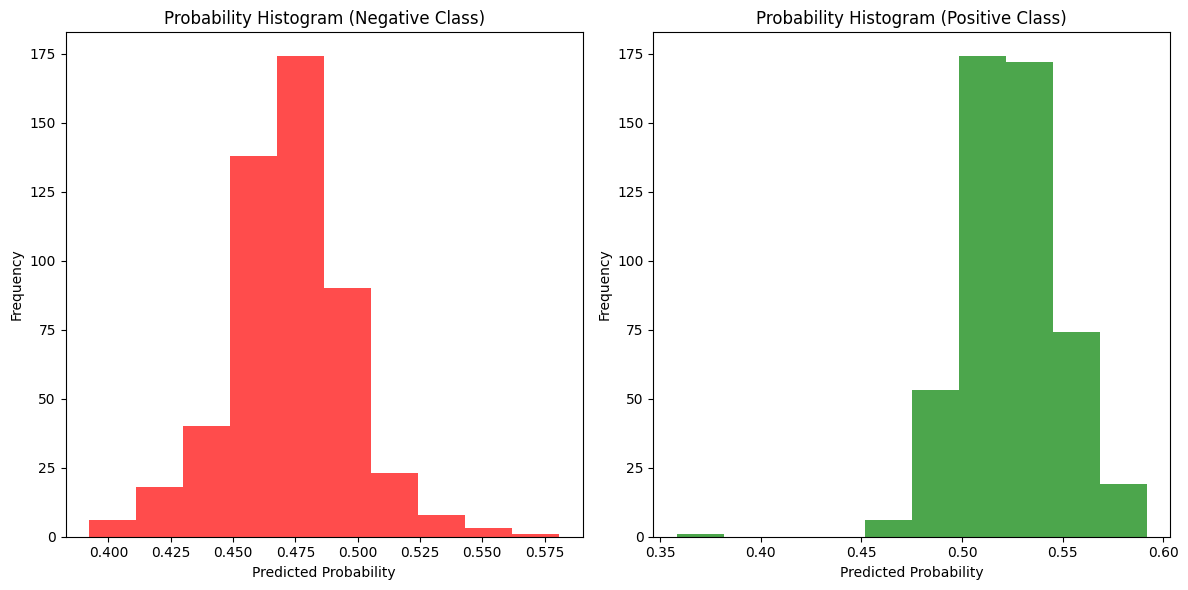

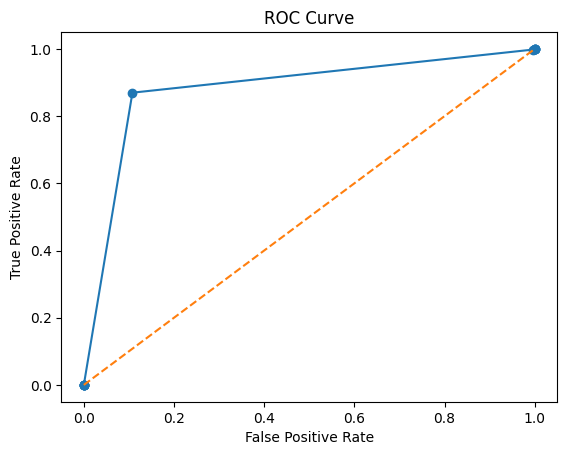

{'Confusion Matrix': [447, 54, 65, 434],
 'Accuracy': 0.881,
 'Precision': 0.889344262295082,
 'Recall': 0.8697394789579158,
 'Specificity': 0.8922155688622755,
 'F1 Score': 0.8794326241134752}

In [70]:
# TODO: Complete the call for the report with the y_test_prob obtained from the test data
y_test_prob = LogReg_optimum_C_Ridge.predict_proba(X_test)
classification_report(y_test, y_test_prob, positive_label =1)

Plot here the differences between the weights for the non-regularized model and the Ridge-regularized one you just obtained.

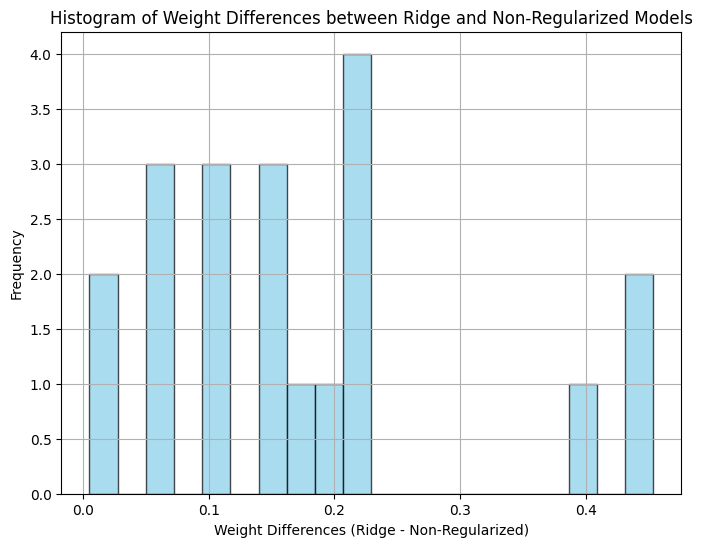

In [71]:
# Calculate the differences between the weights of the non-regularized and Ridge-regularized models
weight_differences = np.abs(LogReg_optimum_C_Ridge.weights - LogReg.weights)

# Plot the histogram of weight differences
plt.figure(figsize=(8, 6))
plt.hist(weight_differences, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Weight Differences (Ridge - Non-Regularized)')
plt.ylabel('Frequency')
plt.title('Histogram of Weight Differences between Ridge and Non-Regularized Models')
plt.grid(True)
plt.show()


**What do you see when you compare this with the original (non-regularized) model?**


 El modelo sigue siendo muy malo, incluso respecto al modelo sin regularizar. El modelo regularizado muestra una pequeña mejora en la curva de calibración, auqneu sigue siendo muy mala.

### Lasso

**Lasso regularization is performed introducing what in the objective function?**

Se introduce la norma L1 del vector de coeficientes en la función objetivo del modelo. Este término, penaliza la magnitud absoluta de los coeficientes.
Ajustando el valor de landa (la cual se encuentra en la formula), se puede controlar el equilibrio entre ajustar bien los datos y mantener pequeños los parámetros del modelo, evitando así el sobreajuste.

In [72]:
# We will perform regularization for different values of the regularization parameter
# TODO: Create an array (C_values) that contains 11 values distributed in log-scale, covering
pow_min = -5
pow_max = 4
num_values = 11

# Create an array of 11 values in log-scale from 10^(-5) to 10^4
C_values = np.logspace(pow_min, pow_max, num=num_values)

# Initialize lists to store the final weights and accuracies for each C
weights_evolution = []
accuracies = []


Again, plot and display the following information:
* The evolution for each weight vs. the regularization parameter
* The accuracy of the method vs. the regularization parameter.
    - In this case, mark also the value of the regularization that achieves the highest accuracy
    
**What is the regularization value that achieves highest accuracy?**

Para determinar el valor de regularización que logra la mayor precisión , generalmente se realizan técnicas de búsqueda como la validación cruzada (se evalúa el modelo utilizando diferentes valores de regularización y se selecciona aquel que produce la mayor precisión en un conjunto de datos de validación).

The optimum value of C based on accuracy is: 158.48931924611142


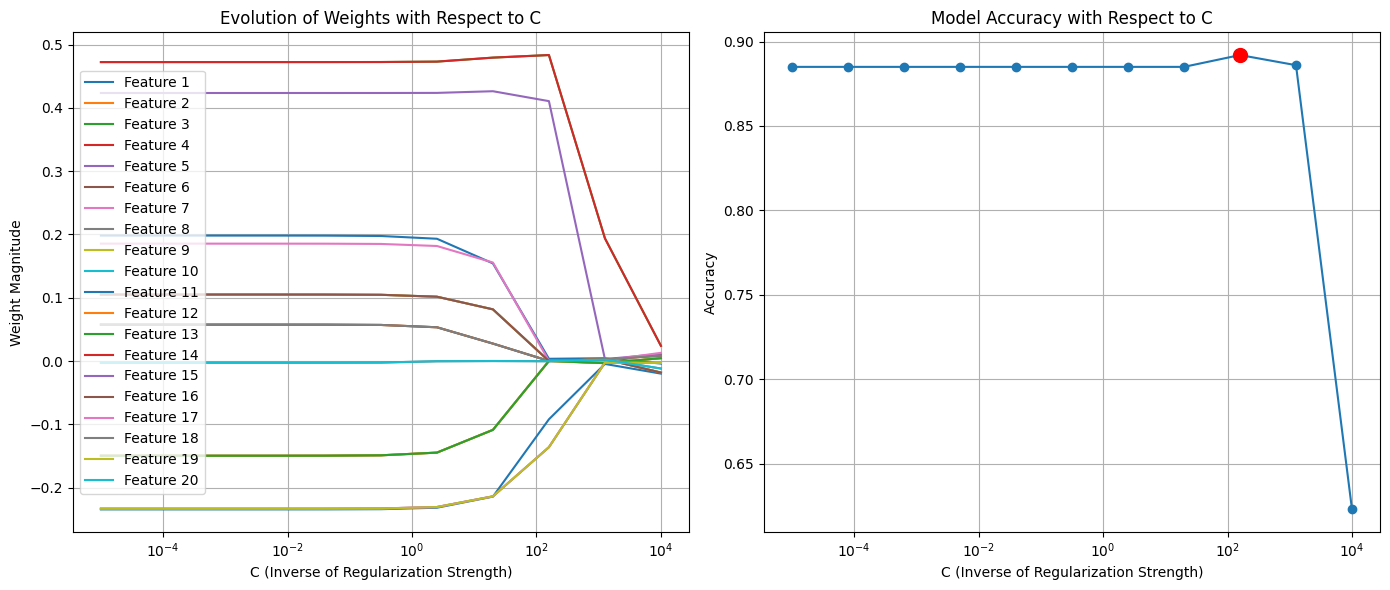

In [73]:
# Assuming the LogisticRegressor class and dataset are prepared
for C in C_values:
    # Initialize model with current C
    model = LogisticRegressor()  # Update to include necessary parameters
    model.fit(X_train, y_train, learning_rate=learning_rate, num_iterations=num_iterations,
              penalty='lasso', C=C)
    weights_evolution.append(model.weights)

    # Predict and calculate accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plotting the evolution of weights
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for feature_index in range(len(weights_evolution[0])):
    weight_trajectory = [weights[feature_index] for weights in weights_evolution]
    plt.plot(C_values, weight_trajectory, label=f'Feature {feature_index + 1}')
plt.xscale('log')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Weight Magnitude')
plt.title('Evolution of Weights with Respect to C')
plt.legend(loc='best')
plt.grid(True)

# TODO: Find the maximum accuracy
max_accuracy = max(accuracies)

# TODO: Filter the C values that correspond to the maximum accuracy
optimum_C_values = [C_values[i] for i, acc in enumerate(accuracies) if acc == max_accuracy]

# TODO: Select the maximum C from those that yield the highest accuracy
optimum_C = max(optimum_C_values)

print(f"The optimum value of C based on accuracy is: {optimum_C}")

# Plotting accuracy as a function of C
plt.subplot(1, 2, 2)
plt.plot(C_values, accuracies, marker='o', linestyle='-')
plt.plot(optimum_C, max_accuracy, 'ro', markersize=10, label='Optimum C')
plt.xscale('log')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Model Accuracy with Respect to C')
plt.grid(True)

plt.tight_layout()
plt.show()

**What difference do you observe when you compare with the Ridge regularization case?**
> Write your answer here: Aqui se puede ver que ya estamos obteniendo resultados con más sentido, pues en los gráficos de evolución de los pesos de las variables ya se muestra como afetan los resultados. En concreto, la variable 15 parece MUY IMPORTANTE, pues cuando su coeficiento llega a 0 la precisión del modelo cae mucho.


Again, create a separate object and train it in the training data with this optimum value of the regularization parameter.

In [74]:
# Initialize the LogisticRegressor model with the optimum C
LogReg_optimum_C_Lasso = LogisticRegressor()

# TODO: Train the model using the training data and the optimum C
LogReg_optimum_C_Lasso.fit(X_train, y_train,
                           learning_rate = learning_rate,
                           num_iterations = num_iterations,
                           penalty = 'lasso',
                           C = optimum_C)

Apply the `classification_report` function and check out the results

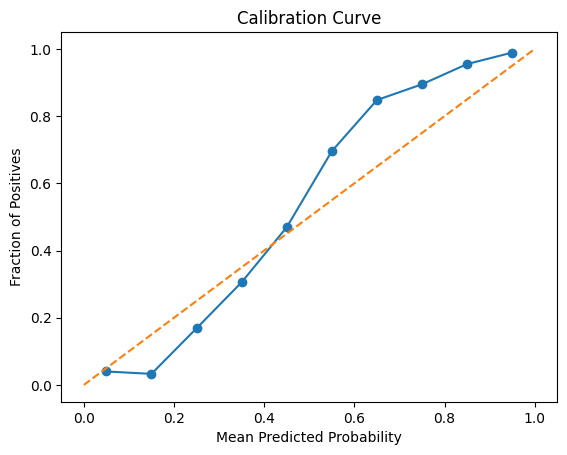

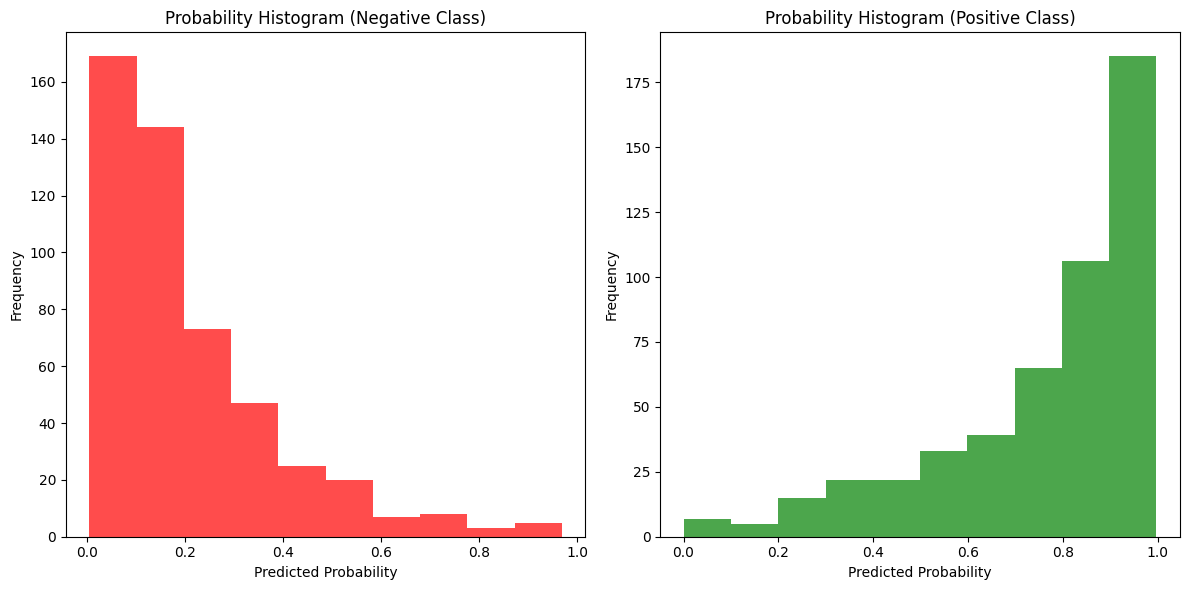

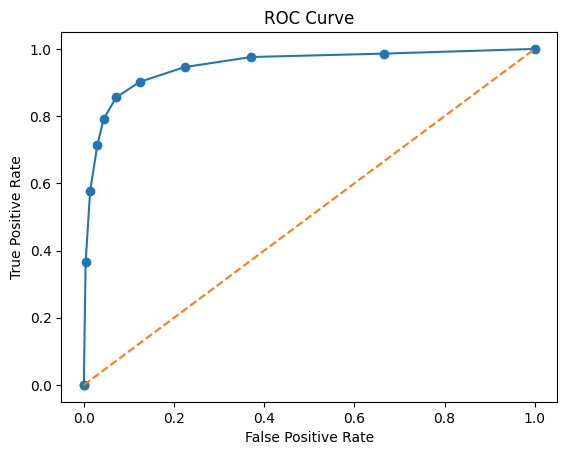

{'Confusion Matrix': [465, 36, 72, 427],
 'Accuracy': 0.892,
 'Precision': 0.9222462203023758,
 'Recall': 0.8557114228456913,
 'Specificity': 0.9281437125748503,
 'F1 Score': 0.8877338877338877}

In [75]:
# TODO: Complete the call for the report with the y_test_prob obtained from the test data
y_test_prob = LogReg_optimum_C_Lasso.predict_proba(X_test)
classification_report(y_test, y_test_prob, 1)

Plot here the differences between the weights for the non-regularized model and this new Lasso-regularized one you just obtained.

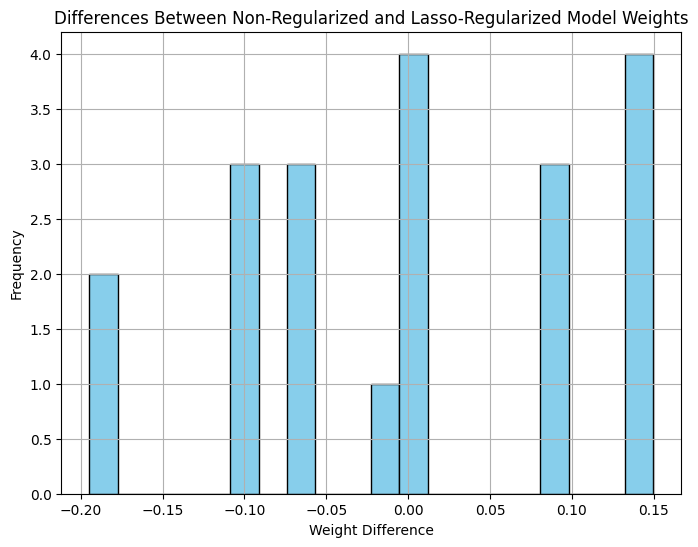

In [76]:
# TODO: Plot an histogram containing the differences between the parameter values for both models
# Initialize the LogisticRegressor model with the optimum C for Lasso regularization
LogReg_optimum_C_Lasso = LogisticRegressor()

# Train the model using the training data and the optimum C for Lasso regularization
LogReg_optimum_C_Lasso.fit(X_train, y_train,
                           learning_rate=learning_rate,
                           num_iterations=num_iterations,
                           penalty='lasso',
                           C=optimum_C)

# Predict probabilities for the test data
y_test_prob = LogReg_optimum_C_Lasso.predict_proba(X_test)

# Generate the classification report for the Lasso-regularized model
#lasso_classification_report = classification_report(y_test, y_test_prob, positive_label=1)
#print("Classification Report (Lasso-Regularized Model):\n", lasso_classification_report)

# Plotting the differences between the weights for the non-regularized model and the Lasso-regularized model
plt.figure(figsize=(8, 6))
weights_difference = LogReg_optimum_C_Lasso.weights - LogReg.weights
plt.hist(weights_difference, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Weight Difference')
plt.ylabel('Frequency')
plt.title('Differences Between Non-Regularized and Lasso-Regularized Model Weights')
plt.grid(True)
plt.show()


**What do you see when you compare this with the original (non-regularized) model?**

> Write your answer here: Aquí se puede ver quel el modelo ha mejorado mucho su capacidad para hacer predicciones más precisas respecto al modelo sin regularizar. El modelo regularizado con lasso tiene  curva de calibración mucho mejor, lo significa que las probabilidades predichas están más cercanas a los valores reales. Además la suavización de la curva ROC indica que el modelo está produciendo predicciones más coherentes.

### ElasticNet

**ElasticNet regularization is performed introducing what in the objective function?**

> Write your answer here: se hace con una fucnión de perdida que mezcla lasso y ridge.

In [83]:
# We will perform regularization for different values of the regularization parameter
# TODO: Create an array (C_values) that contains 11 values distributed in log-scale, covering
pow_min = -5
pow_max = 4

# Create the array of exponents with 11 values
exponents = np.linspace(pow_min, pow_max, 11)

# Generate the C_values array by raising 10 to the power of each exponent
C_values = np.power(10, exponents)

# Print the resulting array
print("C_values:", C_values)


C_values: [1.00000000e-05 7.94328235e-05 6.30957344e-04 5.01187234e-03
 3.98107171e-02 3.16227766e-01 2.51188643e+00 1.99526231e+01
 1.58489319e+02 1.25892541e+03 1.00000000e+04]


Again, plot and display the following information:
* The evolution for each weight vs. the regularization parameter
* The accuracy of the method vs. the regularization parameter.
    - In this case, mark also the value of the regularization that achieves the highest accuracy
    
**What is the regularization value that achieves highest accuracy?**
> Write your answer here
La regularización Elastic Net combina las penalizaciones L1 (Lasso) y L2 (Ridge) en la función objetivo del modelo. Para determinar el valor de regularización que logra la mayor precisión en un modelo Elastic Net, se suelen utilizar técnicas de búsqueda como la validación cruzada.

<ipython-input-82-2171867e5c19>:269: RuntimeWarning: divide by zero encountered in log
  loss = -(1 / m) * np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
<ipython-input-82-2171867e5c19>:269: RuntimeWarning: invalid value encountered in multiply
  loss = -(1 / m) * np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
<ipython-input-82-2171867e5c19>:269: RuntimeWarning: divide by zero encountered in log
  loss = -(1 / m) * np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
<ipython-input-82-2171867e5c19>:269: RuntimeWarning: invalid value encountered in multiply
  loss = -(1 / m) * np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
<ipython-input-82-2171867e5c19>:288: RuntimeWarning: overflow encountered in exp
  sigmoid_value = 1 / (1 + np.exp(-z))


The optimum value of C based on accuracy is: 1258.9254117941662


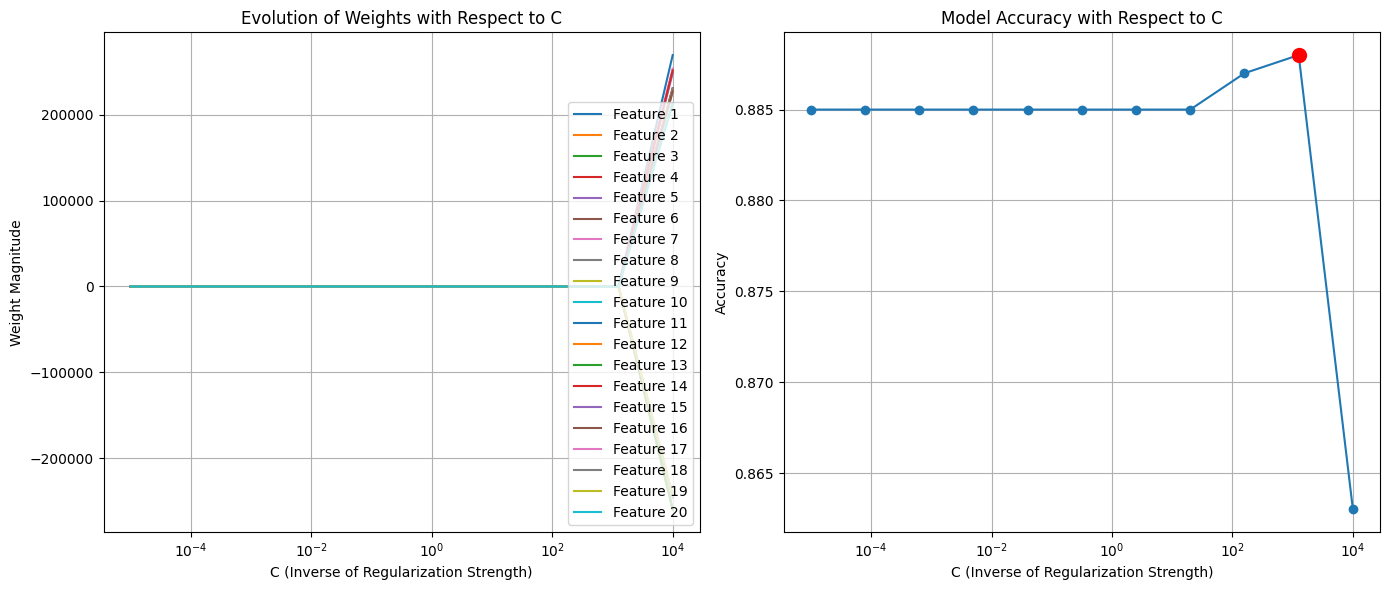

In [84]:
# Assuming the LogisticRegressor class and dataset are prepared
weights_evolution = []
accuracies = []

# Iterate over each value of C
for C in C_values:
    # Initialize model with current C
    model = LogisticRegressor()  # Update to include necessary parameters
    model.fit(X_train, y_train, learning_rate=learning_rate, num_iterations=num_iterations,
              penalty='elasticnet', C=C)
    weights_evolution.append(model.weights)

    # Predict and calculate accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plotting the evolution of weights
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for feature_index in range(len(weights_evolution[0])):
    weight_trajectory = [weights[feature_index] for weights in weights_evolution]
    plt.plot(C_values, weight_trajectory, label=f'Feature {feature_index + 1}')
plt.xscale('log')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Weight Magnitude')
plt.title('Evolution of Weights with Respect to C')
plt.legend(loc='best')
plt.grid(True)

# Find the maximum accuracy
max_accuracy = max(accuracies)

# Filter the C values that correspond to the maximum accuracy
optimum_C_values = [C_values[i] for i, acc in enumerate(accuracies) if acc == max_accuracy]

# Select the maximum C from those that yield the highest accuracy
optimum_C = max(optimum_C_values)

print(f"The optimum value of C based on accuracy is: {optimum_C}")

# Plotting accuracy as a function of C
plt.subplot(1, 2, 2)
plt.plot(C_values, accuracies, marker='o', linestyle='-')
plt.plot(optimum_C, max_accuracy, 'ro', markersize=10, label='Optimum C')
plt.xscale('log')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Model Accuracy with Respect to C')
plt.grid(True)

plt.tight_layout()
plt.show()


**What difference do you observe when you compare with the Ridge regularization case?**
> Write your answer here

Again, create a separate object and train it in the training data with this optimum value of the regularization parameter.

In [85]:
# Initialize the LogisticRegressor model with the optimum C
LogReg_optimum_C_ElasticNet = LogisticRegressor()

# Train the model using the training data and the optimum C
LogReg_optimum_C_ElasticNet.fit(X_train, y_train,
                                learning_rate=learning_rate,
                                num_iterations=num_iterations,
                                penalty='elasticnet',
                                C=optimum_C)


<ipython-input-82-2171867e5c19>:269: RuntimeWarning: divide by zero encountered in log
  loss = -(1 / m) * np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
<ipython-input-82-2171867e5c19>:269: RuntimeWarning: invalid value encountered in multiply
  loss = -(1 / m) * np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))


Apply the `classification_report` function and check out the results

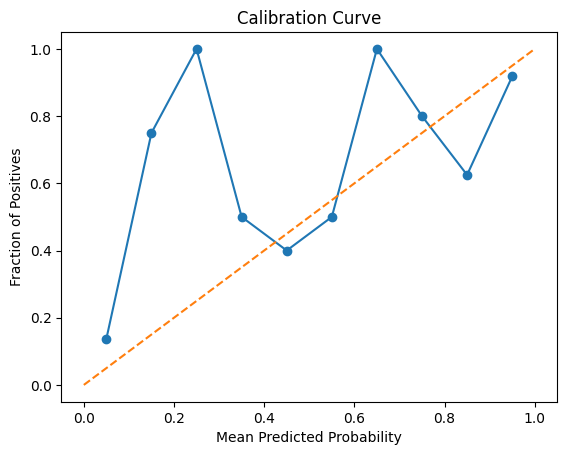

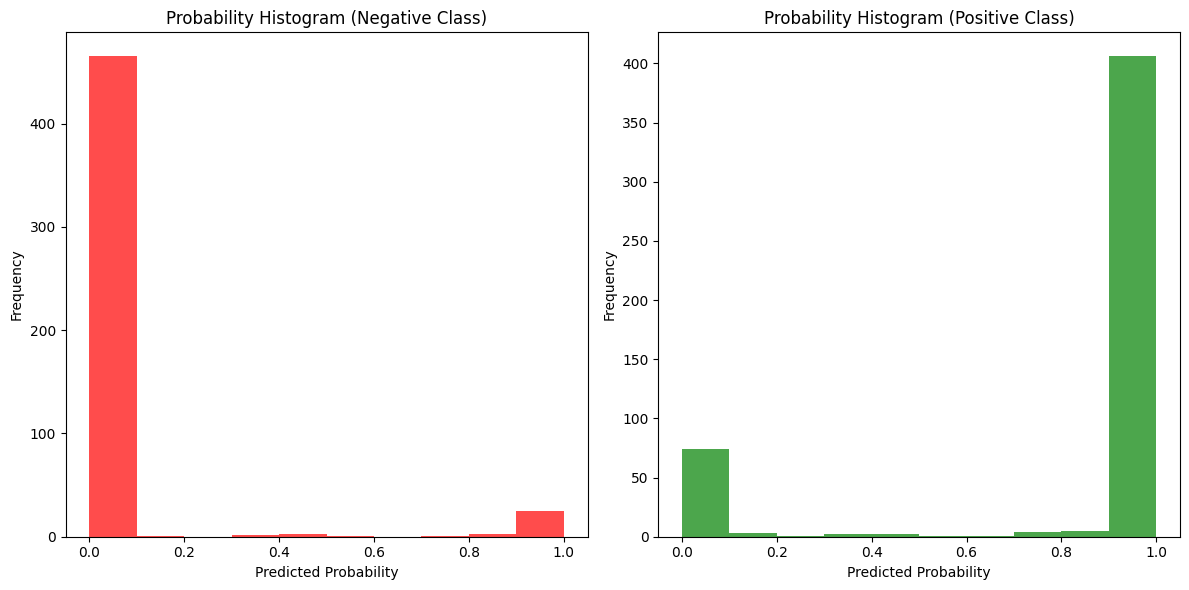

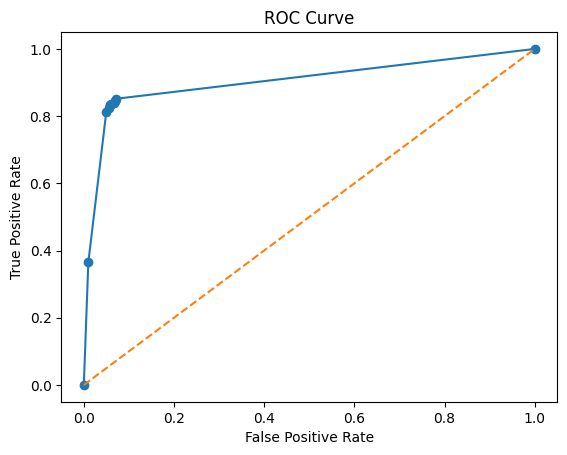

{'Confusion Matrix': [471, 30, 82, 417],
 'Accuracy': 0.888,
 'Precision': 0.9328859060402684,
 'Recall': 0.8356713426853707,
 'Specificity': 0.9401197604790419,
 'F1 Score': 0.8816067653276956}

In [86]:
# TODO: Complete the call for the report with the y_test_prob obtained from the test data
y_test_prob = LogReg_optimum_C_ElasticNet.predict_proba(X_test)
classification_report(y_test, y_test_prob, positive_label=1)


Plot here the differences between the weights for the non-regularized model and this new Lasso-regularized one you just obtained.

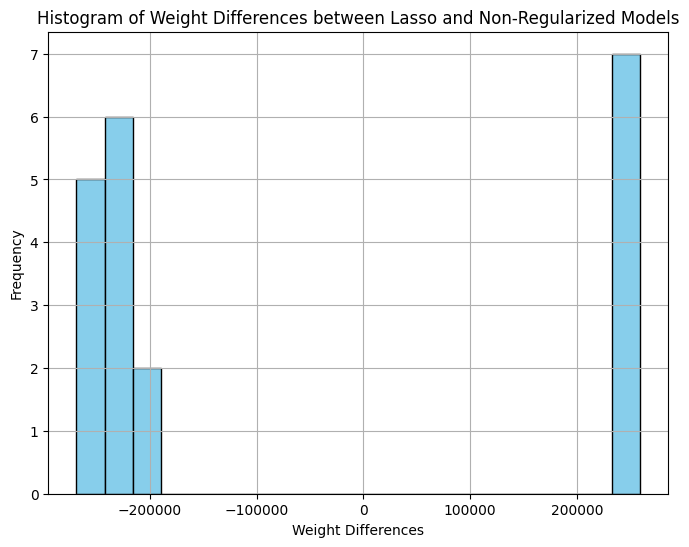

In [87]:
# TODO: Plot an histogram containing the differences between the parameter values for both models
# Get the weights of the non-regularized model
non_regularized_weights = model.weights

# Get the weights of the Lasso-regularized model
lasso_regularized_weights = LogReg_optimum_C_Lasso.weights

# Calculate the differences between the weights
weight_differences = lasso_regularized_weights - non_regularized_weights

# Plotting the histogram of weight differences
plt.figure(figsize=(8, 6))
plt.hist(weight_differences, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Weight Differences')
plt.ylabel('Frequency')
plt.title('Histogram of Weight Differences between Lasso and Non-Regularized Models')
plt.grid(True)
plt.show()


**What do you see when you compare this with the original (non-regularized) model?**

> Write your answer here: la verdad es que este modelo está haciendo cosas muy raras, lo cual es de esperar (en este caso, con estos datos) ya que está mezclando regularización Ridge, la cual se ha visto antes que a este modelo no le viene muy bien, con regularización de lasso, la cual ha dado muy buenos resultados.

Respecto al modelo sin regularización, se puede decir que la curva de calibración ha mejorado, ya que por lo menos se ajusta un poco y no se queda en el suelo de la gráfica, pero sigue sin ser una buena curva. Además, la curva ROC se ha suavizado un poco, lo cual es bueno.



---

**Comparing the un-regularized model with the three other versions with regularization, what do you observe? What can you conclude about the complete analysis?**

> Write your answer here: En general, los modelos regularizados sirven para evitar el sobreajuste (overfitting) y mejorar la capacidad de generalización del modelo. Se busca encontrar un equilibrio entre ajustarse bien a los datos de entrenamiento y que aún asi con los datos del test tenga una buena performance. Para este modelo, sin lugar a duda, la mejor regularización es la de LASSO.

